# Convolutional Neural Networks

## Project: Landmark Classification & Tagging for Social Media Project


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)


### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset



In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.ImageFolder('/content/drive/MyDrive/landmark_images/train', transform=transform)
test_data = datasets.ImageFolder('/content/drive/MyDrive/landmark_images/test', transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

classes=''
# Save image classes
n_classes = len(train_data.classes)
for class_ in train_data.classes:
    classes += class_.split(".")[1].replace("_", " ")

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


**Question 1:** Describe your chosen procedure for preprocessing the data.
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:

- By resizing images to 256X256, images need to be resized to a fixed size before inputting them.
- Yes, Through Rotation.

### (IMPLEMENTATION) Visualize a Batch of Training Data


In [3]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

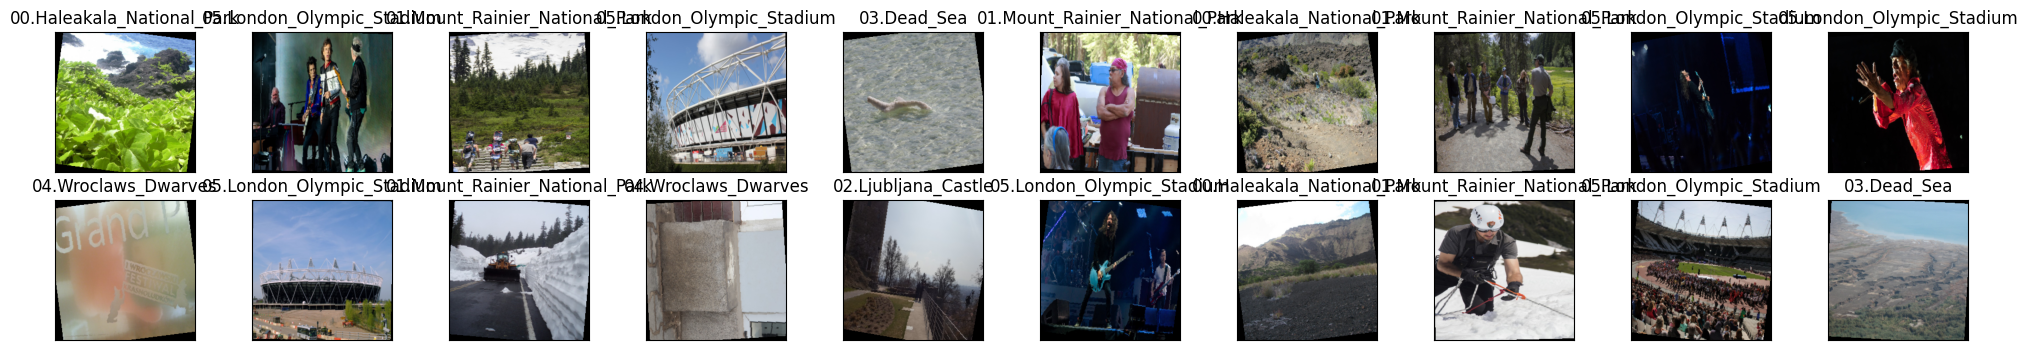

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_data.classes[labels[idx]])

### Initialize use_cuda variable

In [5]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [6]:
## TODO: select loss function

import torch.optim as optim

criterion_scratch = torch.nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    return optimizer


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self, constant_weight=None):
        super(Net, self).__init__()

        ## Define layers of a CNN

        # convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 256, 3, padding=1)
        self.conv3 = nn.Conv2d(256, 512, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 50)

        # dropout layer (p=0.1)
        self.dropout = nn.Dropout(0.1)


    def forward(self, x):
        ## Define forward behavior

        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # flatten image input
        x = x.view(-1, 32 * 32 * 512)

        # add dropout layer
        x = self.dropout(x)

        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))

        # add dropout layer
        x = self.dropout(x)

        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))

        # add dropout layer
        x = self.dropout(x)

        # add output layer
        x = self.fc3(x)

        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.

__Answer:__

CNN model architecture:

- Conv1 - 256x256 64, relu activation function, Max pooling using a 2x2 kernel and a stride of 2
- Conv2 - 128x128 256, relu activation function, Max pooling using a 2x2 kernel and a stride of 2
- Conv3 - 64x64 512, relu activation function, Max pooling using a 2x2 kernel and a stride of 2

- Dropout of p=0.1
- Fully connected layer (32 * 32 * 512, 256), relu activation function
- Dropout of p=0.1
- Fully connected layer (256, 128), relu activation function
- Dropout of p=0.1
- Fully connected layer (128, 50)


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [8]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))


        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss


    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization


In [9]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#

model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.179939 	Validation Loss: 2.324547
Validation loss decreased (inf --> 2.324547).  Saving model ...
Epoch: 2 	Training Loss: 1.995983 	Validation Loss: 1.901843
Validation loss decreased (2.324547 --> 1.901843).  Saving model ...
Epoch: 3 	Training Loss: 1.830484 	Validation Loss: 2.118876
Epoch: 4 	Training Loss: 1.743296 	Validation Loss: 1.660065
Validation loss decreased (1.901843 --> 1.660065).  Saving model ...
Epoch: 5 	Training Loss: 1.684186 	Validation Loss: 1.630166
Validation loss decreased (1.660065 --> 1.630166).  Saving model ...
Epoch: 6 	Training Loss: 1.607556 	Validation Loss: 1.453772
Validation loss decreased (1.630166 --> 1.453772).  Saving model ...
Epoch: 7 	Training Loss: 1.503712 	Validation Loss: 1.633362
Epoch: 8 	Training Loss: 1.498263 	Validation Loss: 1.430702
Validation loss decreased (1.453772 --> 1.430702).  Saving model ...
Epoch: 9 	Training Loss: 1.469000 	Validation Loss: 1.378485
Validation loss decreased (1.430702 --> 1.

### (IMPLEMENTATION) Train and Validate the Model


In [10]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 10

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 2.824746 	Validation Loss: 2.212101
Validation loss decreased (inf --> 2.212101).  Saving model ...
Epoch: 2 	Training Loss: 1.975995 	Validation Loss: 1.932301
Validation loss decreased (2.212101 --> 1.932301).  Saving model ...
Epoch: 3 	Training Loss: 1.830787 	Validation Loss: 1.673837
Validation loss decreased (1.932301 --> 1.673837).  Saving model ...
Epoch: 4 	Training Loss: 1.666514 	Validation Loss: 1.682501
Epoch: 5 	Training Loss: 1.616018 	Validation Loss: 1.541045
Validation loss decreased (1.673837 --> 1.541045).  Saving model ...
Epoch: 6 	Training Loss: 1.532747 	Validation Loss: 1.567056
Epoch: 7 	Training Loss: 1.515949 	Validation Loss: 1.682836
Epoch: 8 	Training Loss: 1.478160 	Validation Loss: 1.475173
Validation loss decreased (1.541045 --> 1.475173).  Saving model ...
Epoch: 9 	Training Loss: 1.439518 	Validation Loss: 1.492902
Epoch: 10 	Training Loss: 1.378907 	Validation Loss: 1.392233
Validation loss decreased (1.475173 --> 1.392233)

### (IMPLEMENTATION) Test the Model


In [11]:
import torch

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.355763


Test Accuracy: 52% (78/150)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)



In [13]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.ImageFolder('/content/drive/MyDrive/landmark_images/train', transform=transform)
test_data = datasets.ImageFolder('/content/drive/MyDrive/landmark_images/test', transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

classes=''
# Save image classes
n_classes = len(train_data.classes)
for class_ in train_data.classes:
    classes += class_.split(".")[1].replace("_", " ")

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [14]:
## TODO: select loss function
import torch.optim as optim

criterion_transfer = torch.nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)
    return optimizer


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [15]:
## TODO: Specify model architecture
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False


n_inputs = model_transfer.classifier[6].in_features

## new layers automatically have requires_grad = True

last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.classifier[6] = last_layer


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 235MB/s]


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__

I opted to utilize the VGG-16 model primarily due to its significant advantage of being trained on an extensive and diverse dataset. This particular model proves to be highly advantageous for our task at hand. One of the key benefits of VGG-16 is that it learns crucial features necessary for landmark classification in its early layers during the pre-training process. As a result, I can choose to keep these lower layers fixed or "frozen" while focusing on utilizing the final layers of the model for our specific classification task.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [17]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

train(2, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer,
      use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.325505 	Validation Loss: 0.548836
Validation loss decreased (inf --> 0.548836).  Saving model ...
Epoch: 2 	Training Loss: 0.334229 	Validation Loss: 0.490912
Validation loss decreased (0.548836 --> 0.490912).  Saving model ...


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [18]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.400862


Test Accuracy: 84% (126/150)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [19]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN

    images = Image.open(img_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    images = transform(images)
    images.unsqueeze_(0)

    if use_cuda:
        images = images.cuda()

    model_transfer.eval()
    output = model_transfer(images)
    top_values, top_idx = output.topk(k)

    top_classes = [train_data.classes[class_id] for class_id in top_idx[0].tolist()]
    return top_classes


# test on a sample image
predict_landmarks('/content/drive/MyDrive/landmark_images/test/03.Dead_Sea/00aeac217d1ed753.jpg', 5)

['03.Dead_Sea',
 '02.Ljubljana_Castle',
 '00.Haleakala_National_Park',
 '05.London_Olympic_Stadium',
 '04.Wroclaws_Dwarves']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

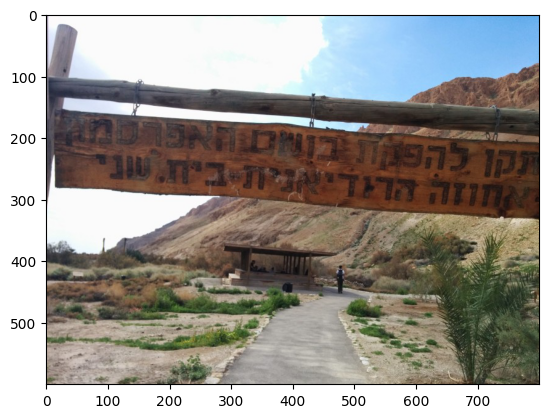

Actual Label: ve
Predicted Label in order: Is this picture of the
 02.Ljubljana_Castle, 03.Dead_Sea, or 00.Haleakala_National_Park?


In [20]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)

    ## TODO: display image and display landmark predictions

    images = Image.open(img_path).convert('RGB')
    plt.imshow(images)
    plt.show()

    print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ').split('.')[0]}")
    print(f"Predicted Label in order: Is this picture of the\n {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")

# test on a sample image
suggest_locations('/content/drive/MyDrive/landmark_images/test/03.Dead_Sea/00aeac217d1ed753.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

Yes, it is better. The network predicts every image successfully.

**Possible points to improve**
- image data augmentation, standardization, auto-scale images
- use Adam optimizer
- try different weight initialization methods

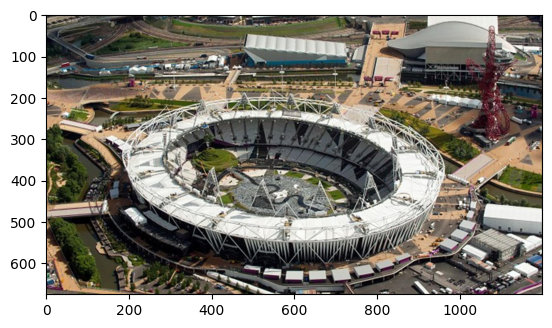

Actual Label: ve
Predicted Label in order: Is this picture of the
 05.London_Olympic_Stadium, 03.Dead_Sea, or 02.Ljubljana_Castle?


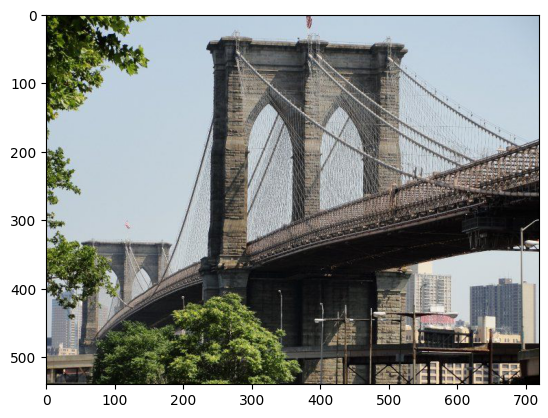

Actual Label: ve
Predicted Label in order: Is this picture of the
 02.Ljubljana_Castle, 05.London_Olympic_Stadium, or 03.Dead_Sea?


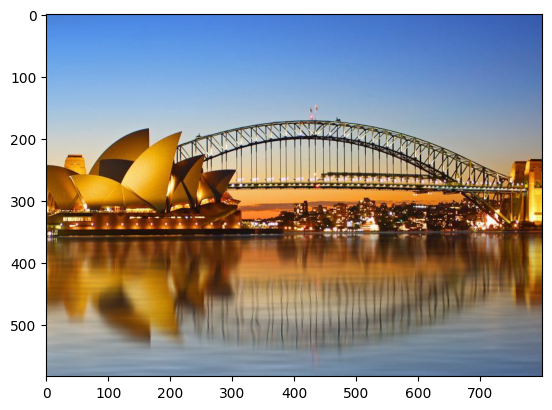

Actual Label: ve
Predicted Label in order: Is this picture of the
 05.London_Olympic_Stadium, 03.Dead_Sea, or 00.Haleakala_National_Park?


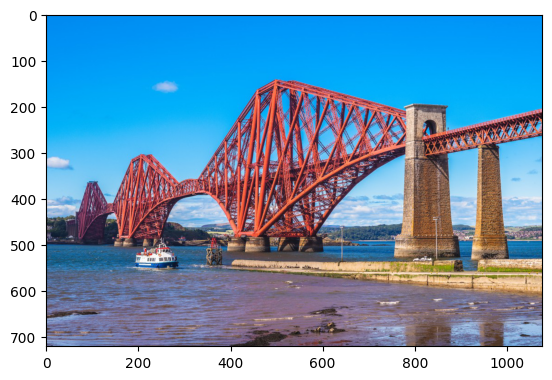

Actual Label: ve
Predicted Label in order: Is this picture of the
 03.Dead_Sea, 05.London_Olympic_Stadium, or 02.Ljubljana_Castle?


In [21]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

import os

for image_path in os.listdir('/content/drive/MyDrive/test_four_images'):
    image_path = os.path.join('/content/drive/MyDrive/test_four_images', image_path)
    if image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        suggest_locations(image_path)